# Análisis del conjunto Breast Cancer Wisconsin (Original)

## Descripción:

En este ejemplo se muestra como usar VSD para mejorar la clasificación de un conjunto de datos

## Procedimiento:

### Instalar los packages necesarios en caso de no haberlo hecho anteriormente

In [1]:
if(!require(car)){
    install.packages('car',repos='http://cran.es.r-project.org')
    require(car)
}
if(!require(C50)){
    install.packages('C50',repos='http://cran.es.r-project.org')
    require(C50)
}
if(!require(gmodels)){
    install.packages('gmodels',repos='http://cran.es.r-project.org')
    require(gmodels)
}
set.seed(606);

Loading required package: car
Loading required package: C50
Loading required package: gmodels


### Leer el conjunto de datos original desde su URL en el repositorio UCI Machine Learning

In [2]:
wdbc=read.table(
    url("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"), 
    sep=",", header=FALSE)

### Obtener las dimensiones (N y d) del conjunto de datos

In [3]:
head(wdbc)
dim(wdbc)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1,1000025,5,1,1,1,2,1,3,1,1,2
2,1002945,5,4,4,5,7,10,3,2,1,2
3,1015425,3,1,1,1,2,2,3,1,1,2
4,1016277,6,8,8,1,3,4,3,7,1,2
5,1017023,4,1,1,3,2,1,3,1,1,2
6,1017122,8,10,10,8,7,10,9,7,1,4


[1] 699  11

### Recodificar los '?' por NA y quedarse solo con los registros completos

In [4]:
wdbc$V7=as.numeric(recode(wdbc$V7, "'?'=NA"))

y=wdbc[complete.cases(wdbc),]

head(y)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
1,1000025,5,1,1,1,2,1,3,1,1,2
2,1002945,5,4,4,5,7,2,3,2,1,2
3,1015425,3,1,1,1,2,3,3,1,1,2
4,1016277,6,8,8,1,3,5,3,7,1,2
5,1017023,4,1,1,3,2,1,3,1,1,2
6,1017122,8,10,10,8,7,2,9,7,1,4


Normalizamos el juego de datos para evitar que unas variables tengan más relevancia que otras, 
simplemente por el hecho de estar expresadas en magnitudes más grandes

In [5]:
x <- as.data.frame(cbind(y[,1],scale(y[,2:11])))
class(x)

[1] "data.frame"

### Particionar el conjunto de entrada en dos (training y test set), según la regla del 2/3

In [6]:
N=dim(x)[1]
all=seq(1,N)

# seleccionar 2/3 al azar

train=sort(sample(N,N*2/3.0))
test=setdiff(all,train)

xtrain=x[train,]
xtest=x[test,]

In [7]:
### Revisar que haya una representación parecida variable clasificadora en el conjunto de entreno y test

In [8]:
prop.table(table(xtrain$V11))
prop.table(table(xtest$V11))


-0.733144027377551   1.36199141487712 
         0.6549451          0.3450549 


-0.733144027377551   1.36199141487712 
         0.6403509          0.3596491 

### Crear un primer árbol usando todos los parámetros por defecto y dibujarlo


Call:
C5.0.default(x = xtrain[, c(2:10)], y = as.factor(xtrain$V11))

Classification Tree
Number of samples: 455 
Number of predictors: 9 

Tree size: 4 

Non-standard options: attempt to group attributes



Call:
C5.0.default(x = xtrain[, c(2:10)], y = as.factor(xtrain$V11))


C5.0 [Release 2.07 GPL Edition]  	Wed Nov 16 16:35:24 2016
-------------------------------

Class specified by attribute `outcome'

Read 455 cases (10 attributes) from undefined.data

Decision tree:

V3 <= -0.3754489: -0.733144027377551 (284/7)
V3 > -0.3754489:
:...V7 > -0.5655993: 1.36199141487712 (151/8)
    V7 <= -0.5655993:
    :...V3 <= 0.6032977: -0.733144027377551 (14/1)
        V3 > 0.6032977: 1.36199141487712 (6)


Evaluation on training data (455 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     4   16( 3.5%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   290     8    (a): class -0.733144027377551
	     8   149    (b): class 1.36199141487712


	Attribute usage:

	100.00%	V3
	 37.58%	V7


Time: 0.0 secs


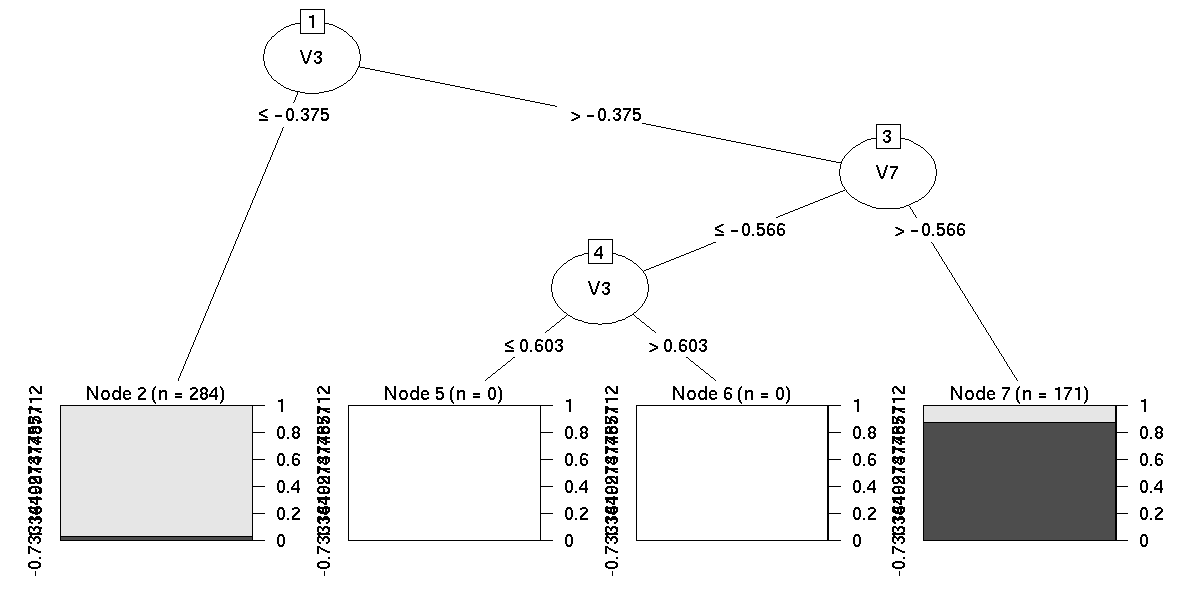

In [9]:
model1 <- C50::C5.0(xtrain[,c(2:10)],as.factor(xtrain$V11))
model1
summary(model1)
options(repr.plot.width=10, repr.plot.height=5)
plot(model1)

### Evaluar el árbol creado mediante la matriz de confusión para cada subconjunto

In [10]:
V11_pred <- predict(model1, xtest)
CrossTable(xtest$V11,V11_pred,prop.chisq=FALSE,prop.c=FALSE,prop.r=FALSE,dnn = c('actual V11','predicted V11'))


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  228 

 
                   | predicted V11 
        actual V11 | -0.733144027377551 |   1.36199141487712 |          Row Total | 
-------------------|--------------------|--------------------|--------------------|
-0.733144027377551 |                137 |                  9 |                146 | 
                   |              0.601 |              0.039 |                    | 
-------------------|--------------------|--------------------|--------------------|
  1.36199141487712 |                  7 |                 75 |                 82 | 
                   |              0.031 |              0.329 |                    | 
-------------------|--------------------|--------------------|--------------------|
      Column Total |                144 |                 84 |                228 | 
-------------------|---------

###  El error del árbol es del 0,07. Solo 16 casos clasifican incorrectamente. Veamos si es mejorable con la técnica de SVD   

### Utilizar SVD para extraer características

In [11]:
TipoCancer <- xtrain[,11]
VarCancer <- xtrain[,2:10]

svdVarCancer <- svd(VarCancer)
svdVarCancerT <- svd(xtest[,2:10])


### Porcentaje de la varianza acumulada explicada 

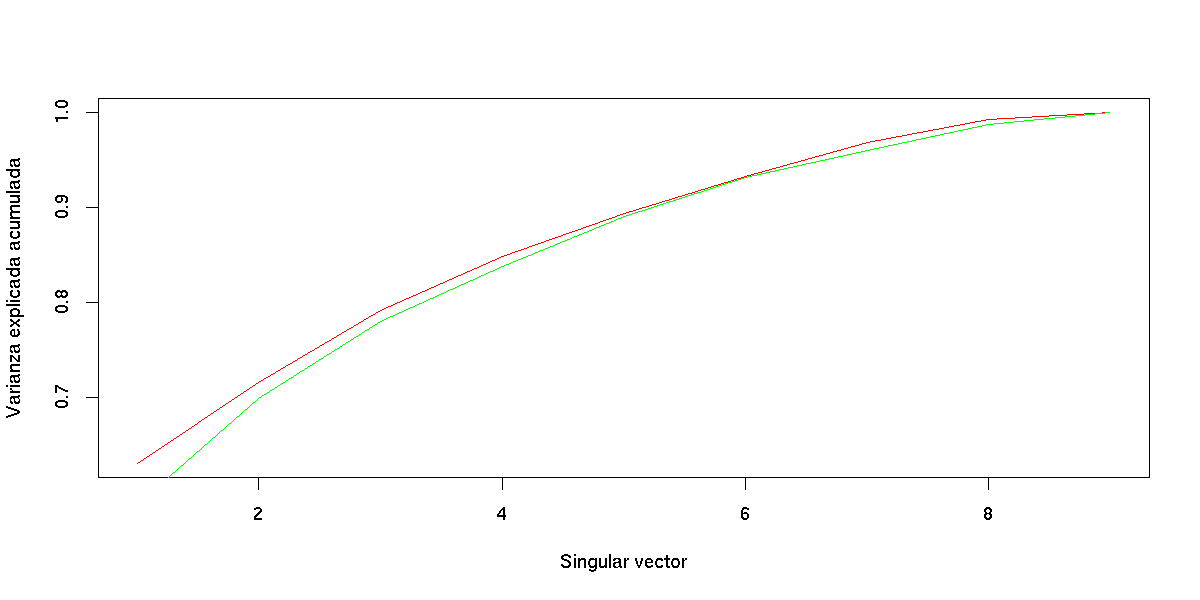

In [12]:
plot(cumsum(svdVarCancer$d^2/sum(svdVarCancer$d^2)),type="l",col="red",xlab="Singular vector",ylab="Varianza explicada acumulada")
lines(cumsum(svdVarCancerT$d^2/sum(svdVarCancerT$d^2)),col="green")



### Añadir una nueva variable C1 a los datos usando el primer SVD que ya acumula 85% de varianza

In [13]:
xtrain$C1=svdVarCancer$u[,1]
xtest$C1=svdVarCancerT$u[,1]

### Crear un segundo árbol con la nueva variable usando todos los parámetros por defecto y dibujarlo


Call:
C5.0.default(x = xtrain[, c(2:10, 12)], y = as.factor(xtrain$V11))

Classification Tree
Number of samples: 455 
Number of predictors: 10 

Tree size: 2 

Non-standard options: attempt to group attributes



Call:
C5.0.default(x = xtrain[, c(2:10, 12)], y = as.factor(xtrain$V11))


C5.0 [Release 2.07 GPL Edition]  	Wed Nov 16 16:35:26 2016
-------------------------------

Class specified by attribute `outcome'

Read 455 cases (11 attributes) from undefined.data

Decision tree:

C1 <= 0.004016426: 1.36199141487712 (164/8)
C1 > 0.004016426: -0.733144027377551 (291/1)


Evaluation on training data (455 cases):

	    Decision Tree   
	  ----------------  
	  Size      Errors  

	     2    9( 2.0%)   <<


	   (a)   (b)    <-classified as
	  ----  ----
	   290     8    (a): class -0.733144027377551
	     1   156    (b): class 1.36199141487712


	Attribute usage:

	100.00%	C1


Time: 0.0 secs


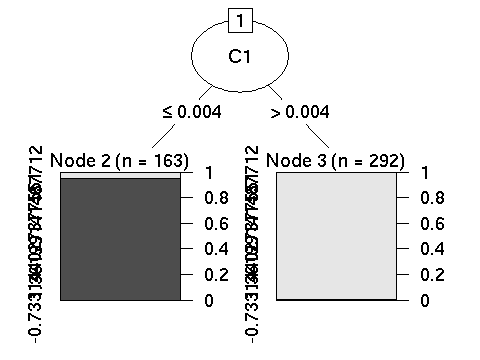

In [14]:
model2 <- C50::C5.0(xtrain[,c(2:10,12)],as.factor(xtrain$V11))
model2
summary(model2)
options(repr.plot.width=4, repr.plot.height=3)
plot(model2)

### Observar que para la creación el árbol solo se ha usado la variable que corresponde con el componente 1. El resto de variables se ha descartado.

### Evaluar el árbol creado mediante la matriz de confusión para cada subconjunto

In [15]:
V11_pred <- predict(model2, xtest)
CrossTable(xtest$V11,V11_pred,prop.chisq=FALSE,prop.c=FALSE,prop.r=FALSE,dnn = c('actual V11','predicted V11'))


 
   Cell Contents
|-------------------------|
|                       N |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  228 

 
                   | predicted V11 
        actual V11 | -0.733144027377551 |   1.36199141487712 |          Row Total | 
-------------------|--------------------|--------------------|--------------------|
-0.733144027377551 |                139 |                  7 |                146 | 
                   |              0.610 |              0.031 |                    | 
-------------------|--------------------|--------------------|--------------------|
  1.36199141487712 |                  0 |                 82 |                 82 | 
                   |              0.000 |              0.360 |                    | 
-------------------|--------------------|--------------------|--------------------|
      Column Total |                139 |                 89 |                228 | 
-------------------|---------

### Tenemos una tasa del 0,096 de error en clasificación.  Ha incrementado.  Hemos logrado reducir las clasificaciones erroneas de tumor maligno a 0 reduciendose la misma tasa de falsos positivos de 9 a 7.